In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [5]:
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCRCatalogs import GCRQuery

In [6]:
GCRCatalogs.get_public_catalog_names()

['desc_cosmodc2',
 'desc_dc2_run2.2i_dr6_object',
 'desc_dc2_run2.2i_dr6_object_with_truth_match',
 'desc_dc2_run2.2i_dr6_truth',
 'desc_dc2_run2.2i_truth_galaxy_summary',
 'desc_dc2_run2.2i_truth_sn_summary',
 'desc_dc2_run2.2i_truth_sn_variability',
 'desc_dc2_run2.2i_truth_star_summary',
 'desc_dc2_run2.2i_truth_star_variability']

In [7]:
GCRCatalogs.get_root_dir()

'/Users/sarahdraves/Documents/DESC_Data'

In [13]:
print(GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_truth').available_tracts)

[3830, 3831, 4028, 4029]


In [14]:
print(GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_object').available_tracts)

[3830, 3831, 4028, 4029]


In [15]:
match_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_object_with_truth_match')

In [16]:
data = match_cat.get_quantities(["mag_r_cModel", "mag_r_truth", "match_sep", "is_good_match", "is_nearest_neighbor"], native_filters=[tract_filter(3830)])

In [18]:
(data["is_good_match"] | data["is_nearest_neighbor"]).all()

True

In [19]:
# Most "good matches" (sep. < 1 arcsec, dmag < 1 mag) would also happen to be nearest neighbors (NN). 
# "Not good" matches can be due to either large separation or large magnitude difference. 

# Let's define a few masks to distinguish these cases:

dmag = np.abs(data["mag_r_truth"] - data["mag_r_cModel"])

good_and_nn = data["is_good_match"] & data["is_nearest_neighbor"]     # Good matches that happen to be the nearest neighbor (NN) too
good_not_nn = data["is_good_match"] & (~data["is_nearest_neighbor"])  # Good matches that are not the nearest neighbor (NN)
not_good_small_dmag = (~data["is_good_match"]) & (dmag < 1)           # Not good matches that have dmag < 1 mag (so they must have sep > 1 arcsec)
not_good_large_dmag = (~data["is_good_match"]) & ((dmag >= 1) | np.isnan(dmag))  # Not good matches that have dmag > 1 mag or undefined mag
# These four masks are mutually exclusive:

(np.vstack([good_and_nn, good_not_nn, not_good_small_dmag, not_good_large_dmag]).astype(np.int64).sum(axis=0) == 1).all()

True

/var/folders/zd/14hqhh8n6v122yj77t47nyv40000gn/T/ipykernel_10926/3632931394.py:15: RuntimeWarning: invalid value encountered in divide
  frac = np.histogram(data["match_sep"][mask], bins=sep_bins)[0] / hist


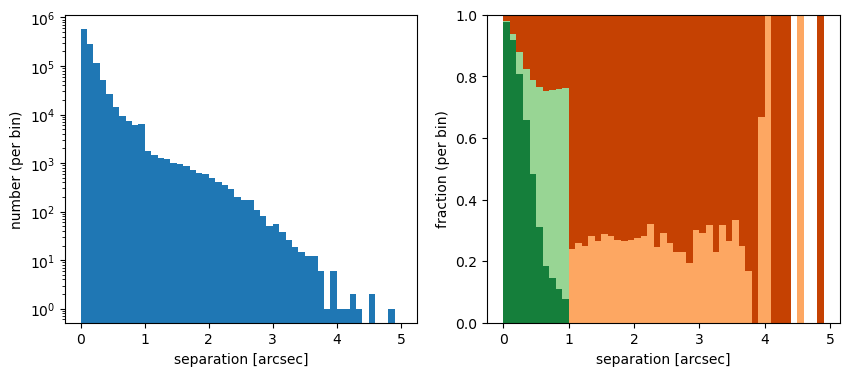

In [20]:
sep_bins = np.linspace(0, 5, 51)
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), dpi=100)

hist = ax[0].hist(data["match_sep"], bins=sep_bins)[0]
ax[0].set_yscale("log");
ax[0].set_xlabel("separation [arcsec]");
ax[0].set_ylabel("number (per bin)");


bottom = None
for mask, color in zip(
    [good_and_nn, good_not_nn, not_good_small_dmag, not_good_large_dmag],
    [plt.cm.Greens(0.8), plt.cm.Greens(0.4), plt.cm.Oranges(0.4), plt.cm.Oranges(0.8)]
):
    frac = np.histogram(data["match_sep"][mask], bins=sep_bins)[0] / hist
    ax[1].bar(sep_bins[:-1], frac, width=np.ediff1d(sep_bins), bottom=bottom, align="edge", color=color)
    if bottom is None:
        bottom = frac
    else:
        bottom += frac
        
ax[1].set_xlabel("separation [arcsec]");
ax[1].set_ylabel("fraction (per bin)");

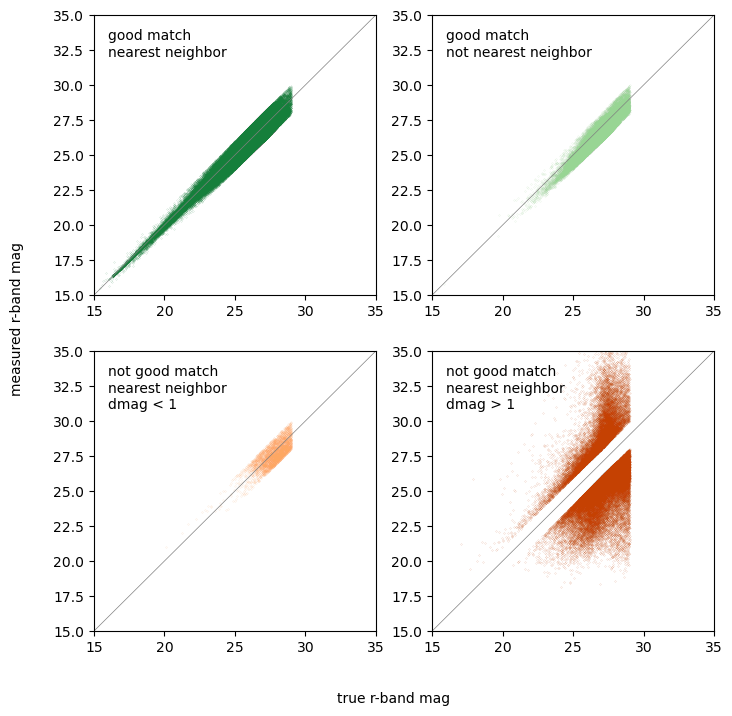

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=100)

for mask, color, label, ax_this in zip(
    [good_and_nn, good_not_nn, not_good_small_dmag, not_good_large_dmag],
    [plt.cm.Greens(0.8), plt.cm.Greens(0.4), plt.cm.Oranges(0.4), plt.cm.Oranges(0.8)],
    ["good match\nnearest neighbor", "good match\nnot nearest neighbor", "not good match\nnearest neighbor\ndmag < 1", "not good match\nnearest neighbor\ndmag > 1"],
    ax.flat
):
    ax_this.scatter(data["mag_r_truth"][mask], data["mag_r_cModel"][mask], color=color, s=0.005, rasterized=True)
    ax_this.set_xlim(15, 35)
    ax_this.set_ylim(15, 35)
    ax_this.plot([15, 35], [15, 35], color='grey', lw=0.5)
    ax_this.text(16, 34, label, va="top")
    
fig.text(0.5, 0.02, "true r-band mag", ha="center");
fig.text(0.02, 0.5, "measured r-band mag", va="center", rotation=90);